In [1]:
# Imports
%config InlineBackend.figure_format = 'retina'
%pylab inline
import sys
sys.path.append('../../src/')
from helpers import *
from plothelpers import *
from BayesianNamingGame import *

Populating the interactive namespace from numpy and matplotlib


# Combined plot

This visualization combines the langauges used by agents at various timesteps (that is, the $\phi$'s) with the utterances over time (the $\psi$'s).


In [4]:
def run(init_counts=None, setup=None):
    if init_counts:
        setup['init_counts'] = init_counts
    res = BNG_simulation(**setup)
    vs = res['counts'] + setup['alpha']
    ps = vs / vs.sum(axis=1)[:, np.newaxis]
    return ps, res['counts'], res

def get_moving_psi(xs, K, window=1000, interval=1, start=0):
    psis = array([np.histogram(
                a=xs[max(0, t-window):t], 
                bins=K, 
                range=(0,K))[0] 
            for t in range(start, len(xs), interval)])

    # Normalize
    return normalize(psis)
    

def plot_runs(setup, stops=[10, 100, 1000, 10000], runs=2,
             aspect_correction=0.5, window=1000, show_time=False):
    
    # Set up the 'stops' at which the intermediate state of
    # the simulation is plotted
    stops = unique(array([0] + array(stops).tolist()))
    stops.sort()    
    times = stops[1:] - stops[:-1]
    
    # Prior
    alpha = array(setup['alpha'])
    alpha_ps = alpha / alpha.sum()
    K = setup['K']
    
    # Set up figure
    G = gridspec.GridSpec(runs, len(stops)+3)
    cmap = CustomCmap('white', 'orange')
    axes, imgaxes = [], []
    for y in range(runs):
        
        # Show the agent distributions at certain times
        counts, utter = False, np.zeros((0,setup['K']))
        for x, (remaining_time, time) in enumerate(zip(times, stops[1:])):
            sharey = None if x == 0 else axes[-1]
            ax = subplot(G[y,x], sharey=sharey)
            axes.append(ax)
            
            # Continue simulation
            setup['T'] = remaining_time
            ps, counts, res = run(counts, setup=setup)
            utter = np.concatenate((utter, res['utterances'].todense()))
            
            # Plot!
            xs = arange(K)
            pyplot.barh(xs, alpha_ps, color=get_color('orange'))
            plot(ps.mean(axis=0), xs, 'ko-', ms=2, lw=.8)
            plot(ps.T, xs, 'k', lw=.2, alpha=.5)
            sns.despine(ax=ax, bottom=True)
            
            xticks([]); yticks([]);
            if y == 0 and x==0: title(r'Languages used by agents')
            if y == runs-1: xlabel(f'$t = {time}$')
            if x == 0: ylabel(f'simulation {y+1}')
        
        # Words uttered and time average
        if True:
            
            ax = subplot(G[y, -4:-1], sharey=axes[-1])
            axes.append(ax)
            imgaxes.append(ax)
            words = utter.argmax(axis=1)
            
            # Plot moving time average
            psi = get_moving_psi(words, K=K, window=window, start=1)
            M = psi.max(axis=1)[:, np.newaxis]
            m = psi.min(axis=1)[:, np.newaxis]
            psi = (psi - m) / (M-m)#psi.max(axis=1)[:, np.newaxis]
            aspect = int(len(psi) / K * aspect_correction)
            imshow(psi.T, aspect=aspect, interpolation='none', 
                   cmap=CustomCmap('white', 'blue'))
            
            # Plot words
            plot(words, '.', ms=1)
            sns.despine(ax=ax,left=True, bottom=(y != runs-1))
            if y == 0: title('Utterances')
            if y != runs - 1: ax.set_xticks([])
            if y == runs-1 and show_time: ax.set_xlabel('time ($t$)')
                
        # Plot time average
        if True:
            ax = subplot(G[y, -1], sharey=axes[-1])
            axes.append(ax)
            psi, _ = np.histogram(words, bins=K, range=(0, K))
            psi = psi / psi.sum()
            pyplot.barh(xs, alpha_ps, color=get_color('orange'))
            plot(ps.mean(axis=0), xs, 'ko-', ms=2, lw=.5)
            plot(psi, xs, 's-', ms=2, lw=.5, color=get_color('blue'))
            
            sns.despine(ax=ax, bottom=True)
            xticks([]);
            if y == 0:title(r'Time avg. $\psi$')
    
    # Style
    restyle_title(axes[0], axes[4], axes[5], y=1.15)
    return axes
        

/Users/Bas/anaconda/envs/thesis2/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


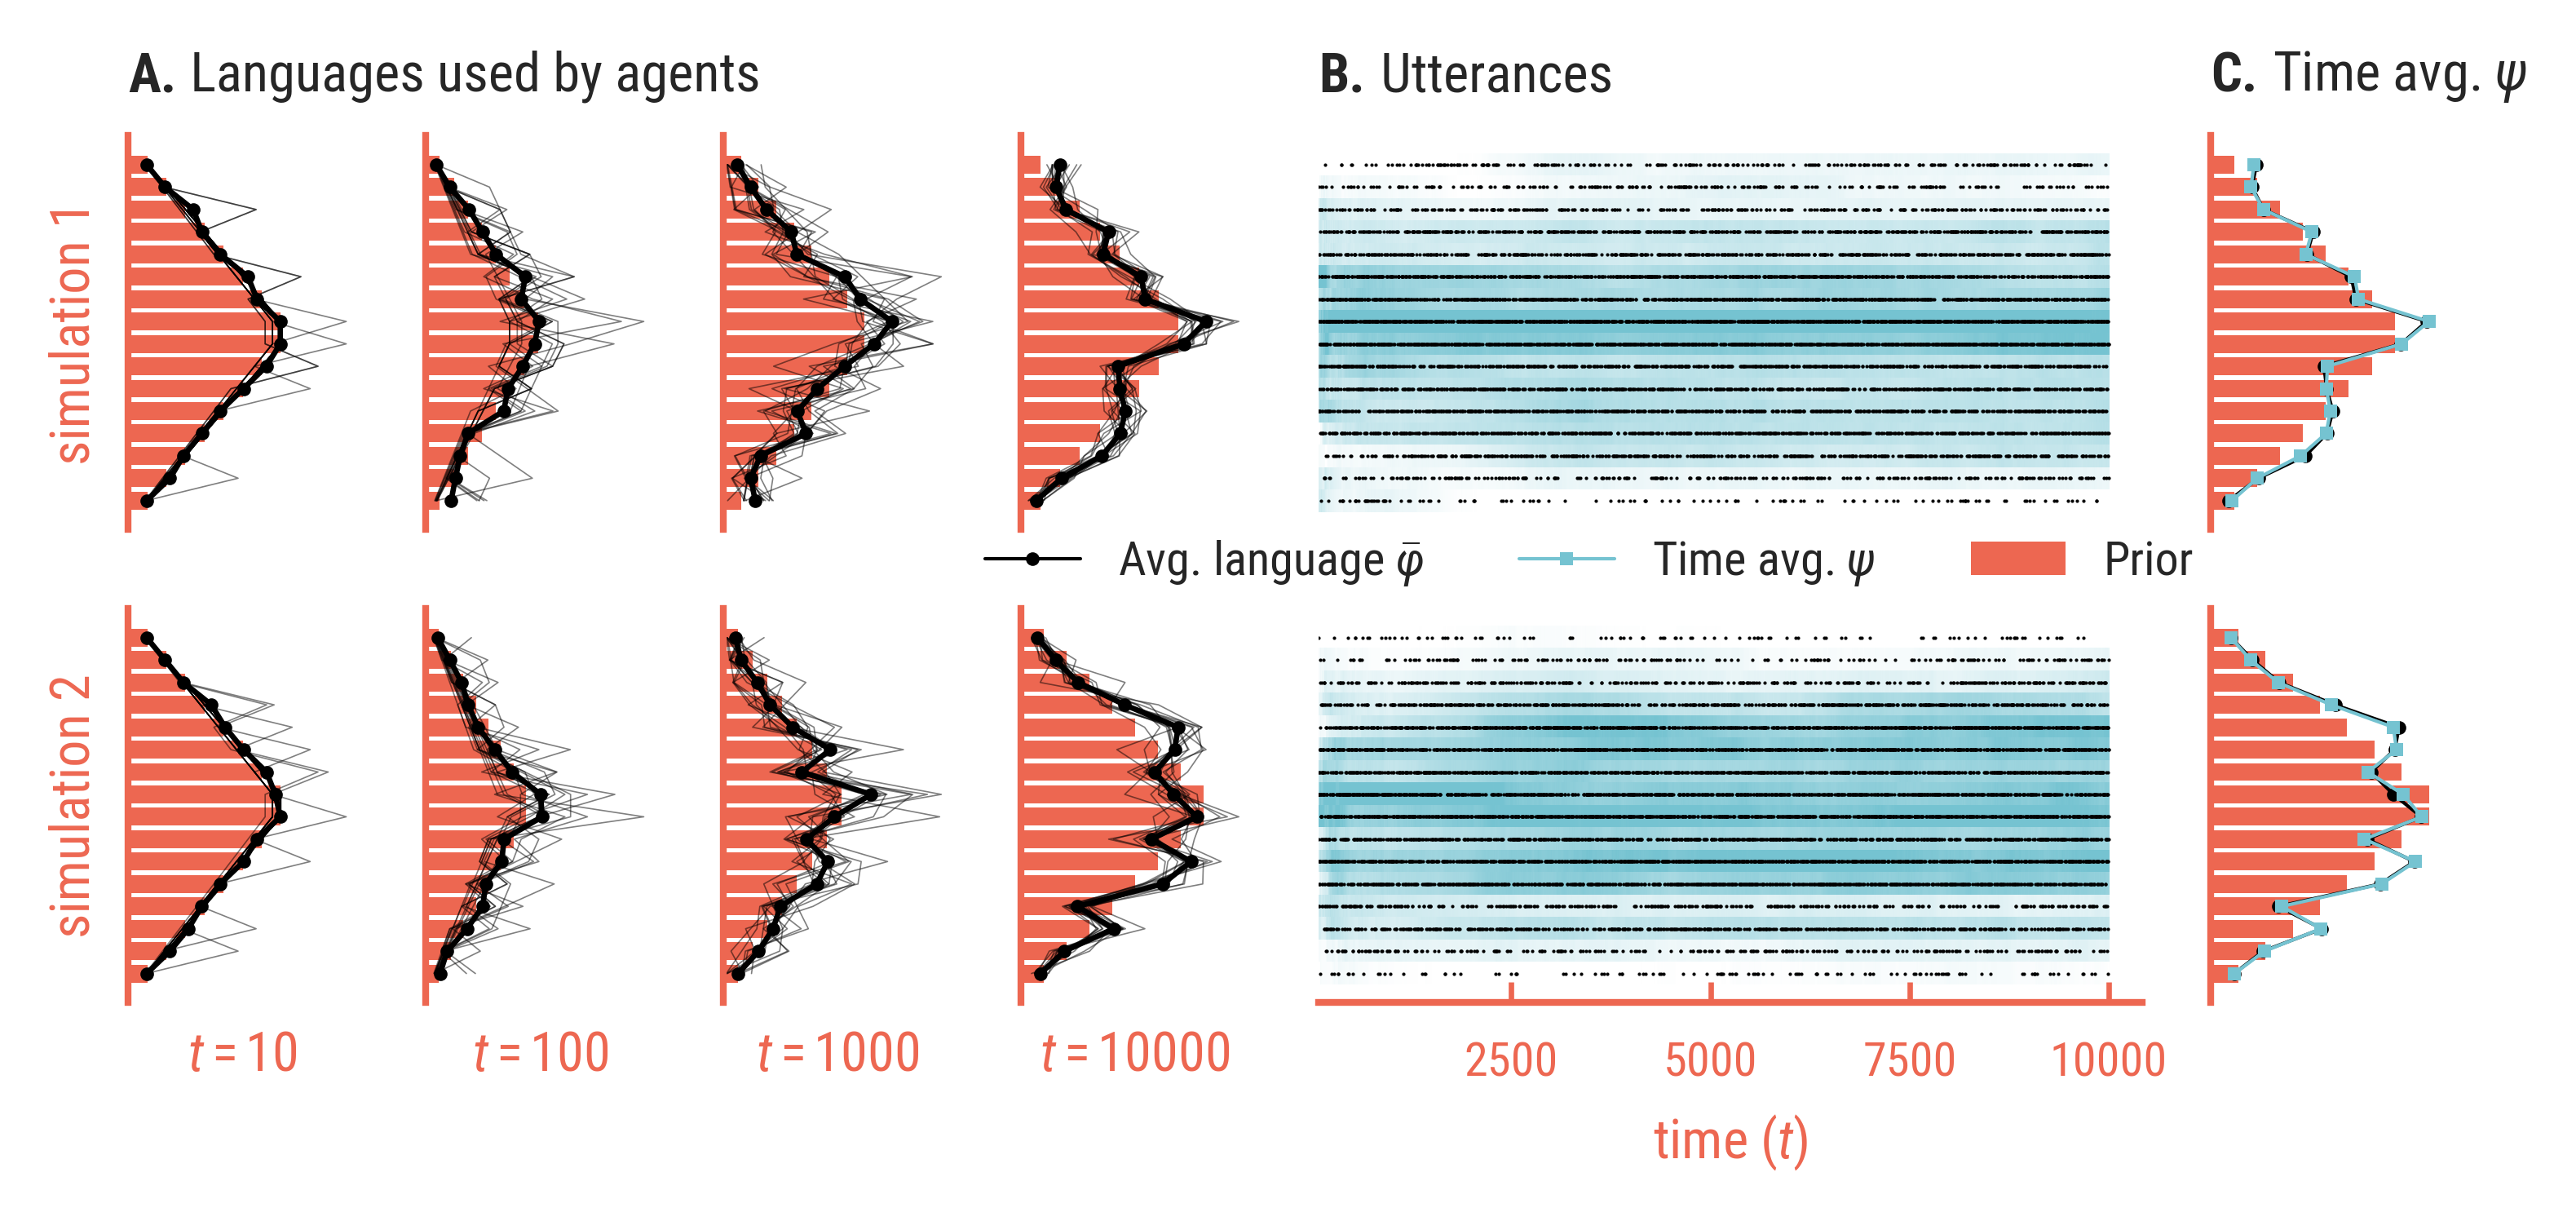

In [6]:
# Plot a single example
K=16
setup = dict(
    T = 5000, 
    num_datapoints = 11, 
    K = K, 
    N = 15,
    b = 1,
    alpha = 1.1*K*get_pis(K)['peak'],
    gamma=1e20,
    zeta = 1,
    eta = 1,
    record=False,
    chain=True,
    record_utterances=True)

figure(figsize=cm2inch(12,4.5))
axes = plot_runs(setup, runs=2, #stops=[10,100,200,300],
          aspect_correction=.45, window = 2000, show_time=True)

axes[-1].get_lines()[0].set_label(r'Avg. language $\bar\varphi$')
axes[-1].get_lines()[1].set_label(r'Time avg. $\psi$')
axes[-1].get_children()[0].set_label('Prior')
legend(bbox_to_anchor=(.05,1.25),  ncol=3, framealpha=0)

subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3)
savefig('FIG05-BNG-gamma-inf-zeta-1-eta-1-legend.png', bbox_inches='tight')
copyfig('FIG05-BNG-gamma-inf-zeta-1-eta-1-legend.png')

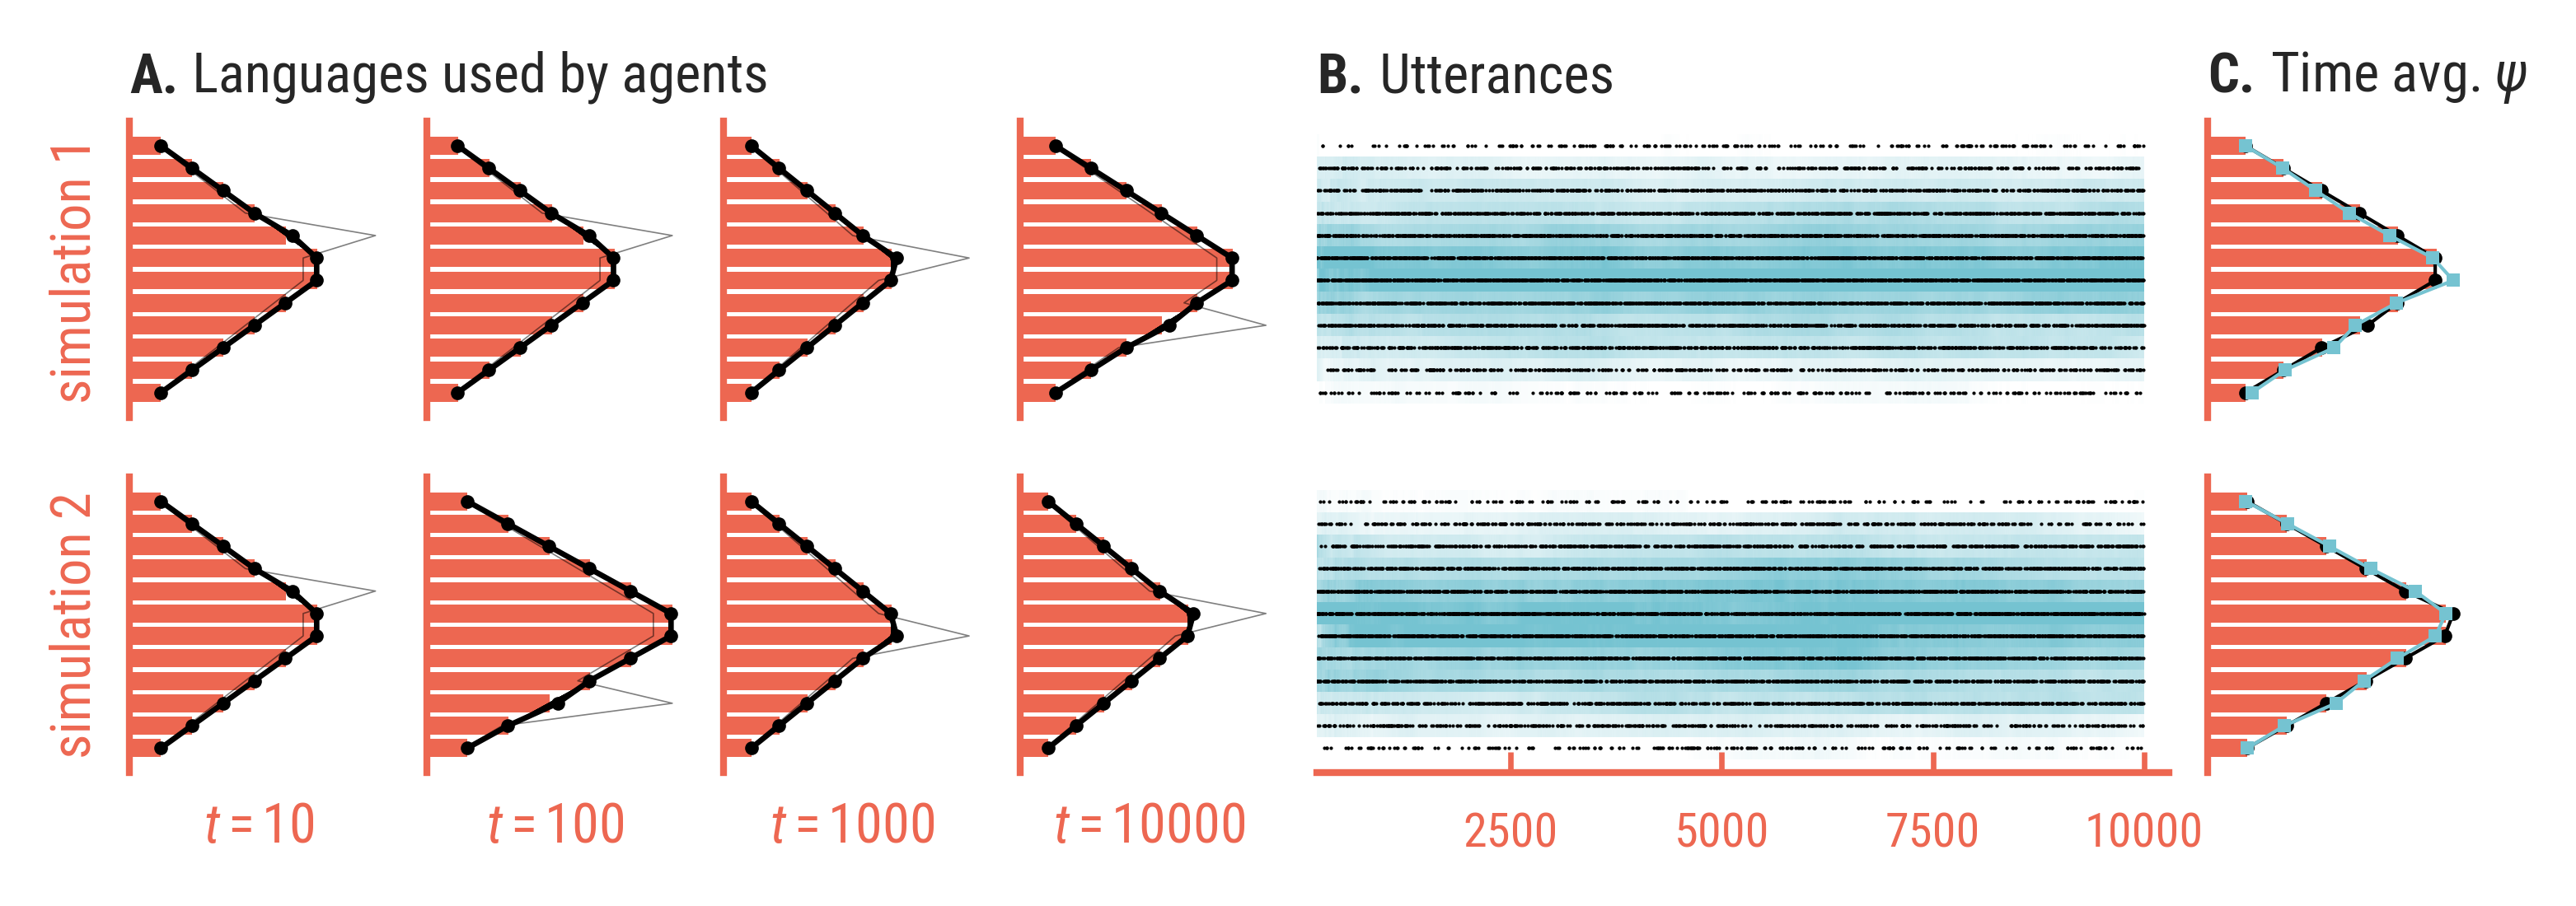

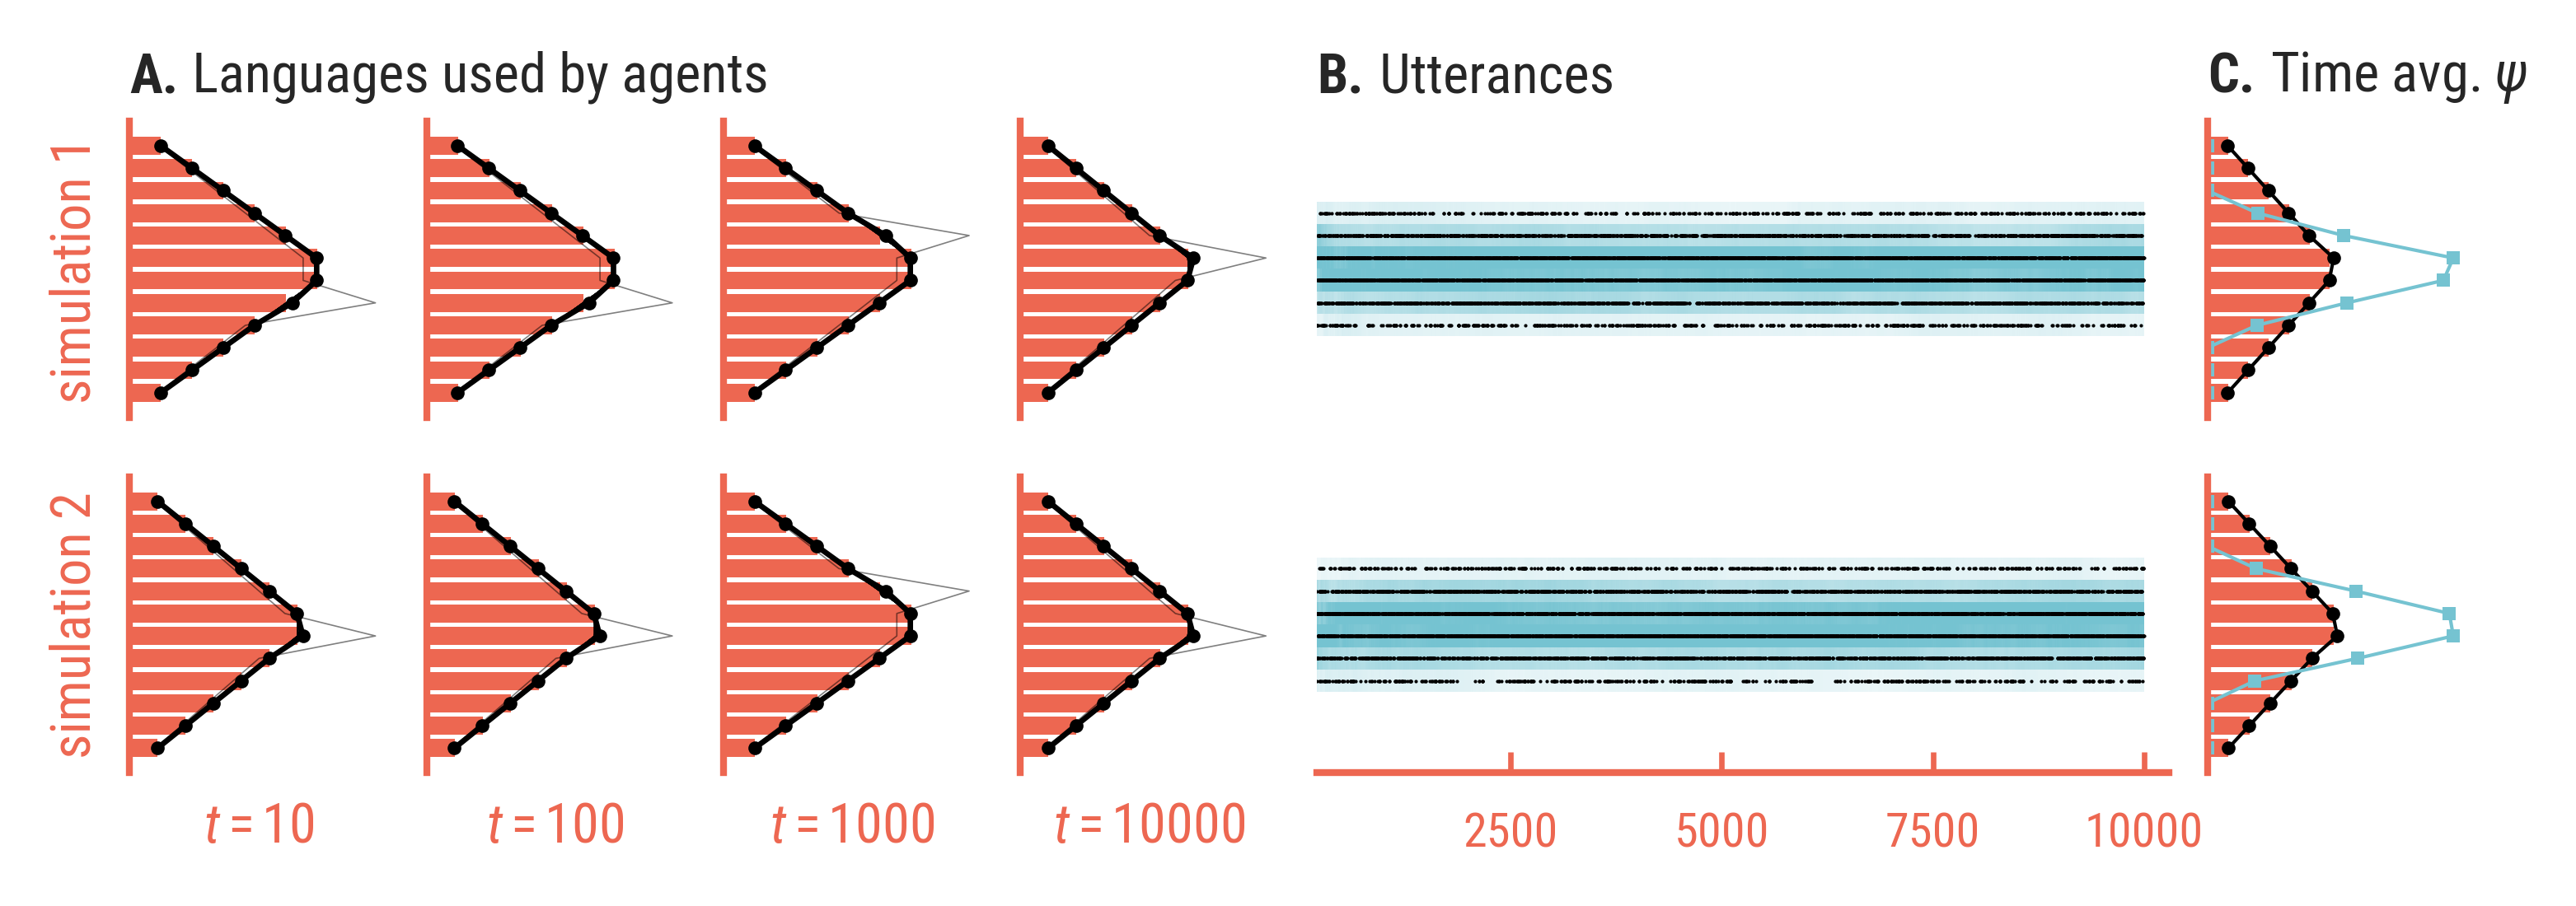

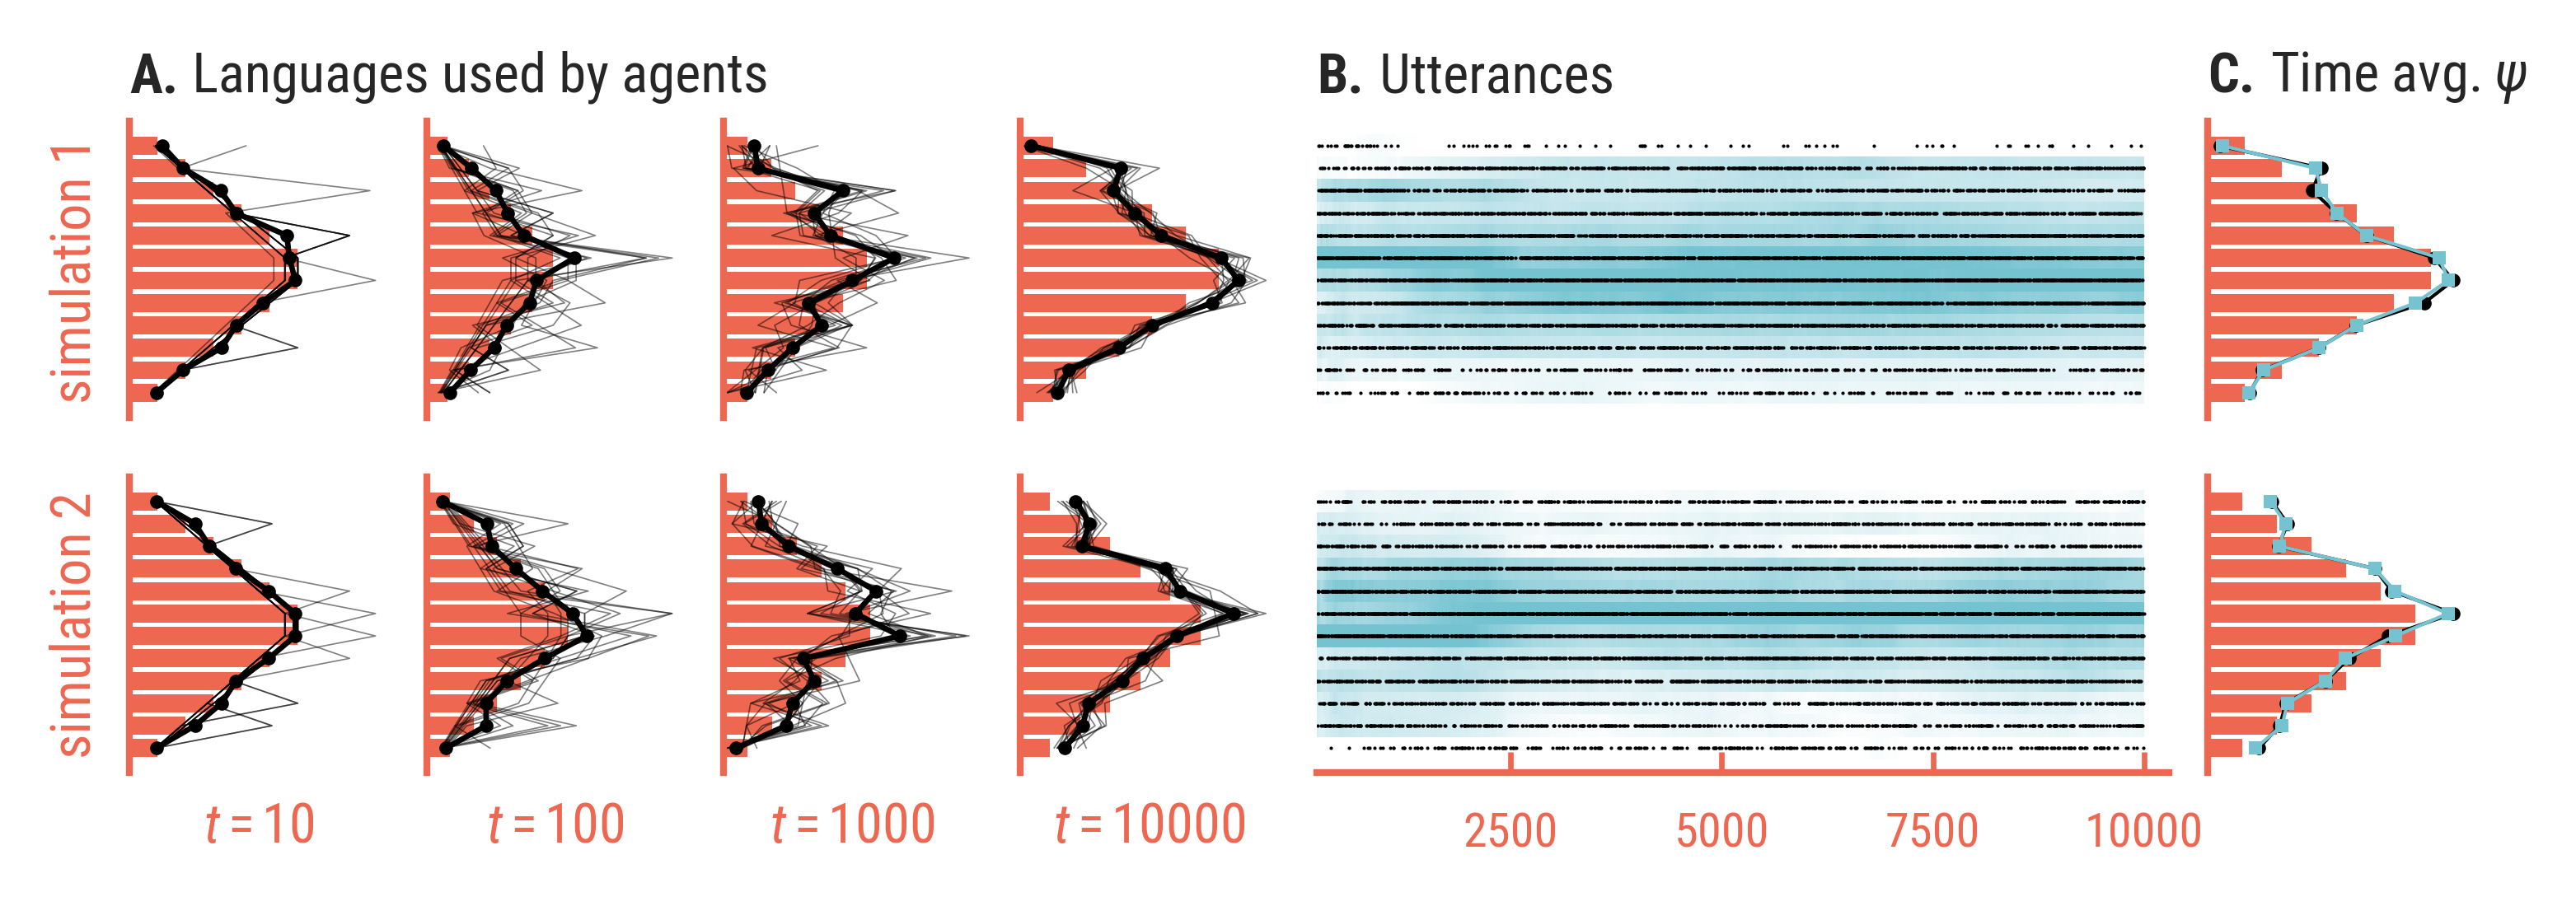

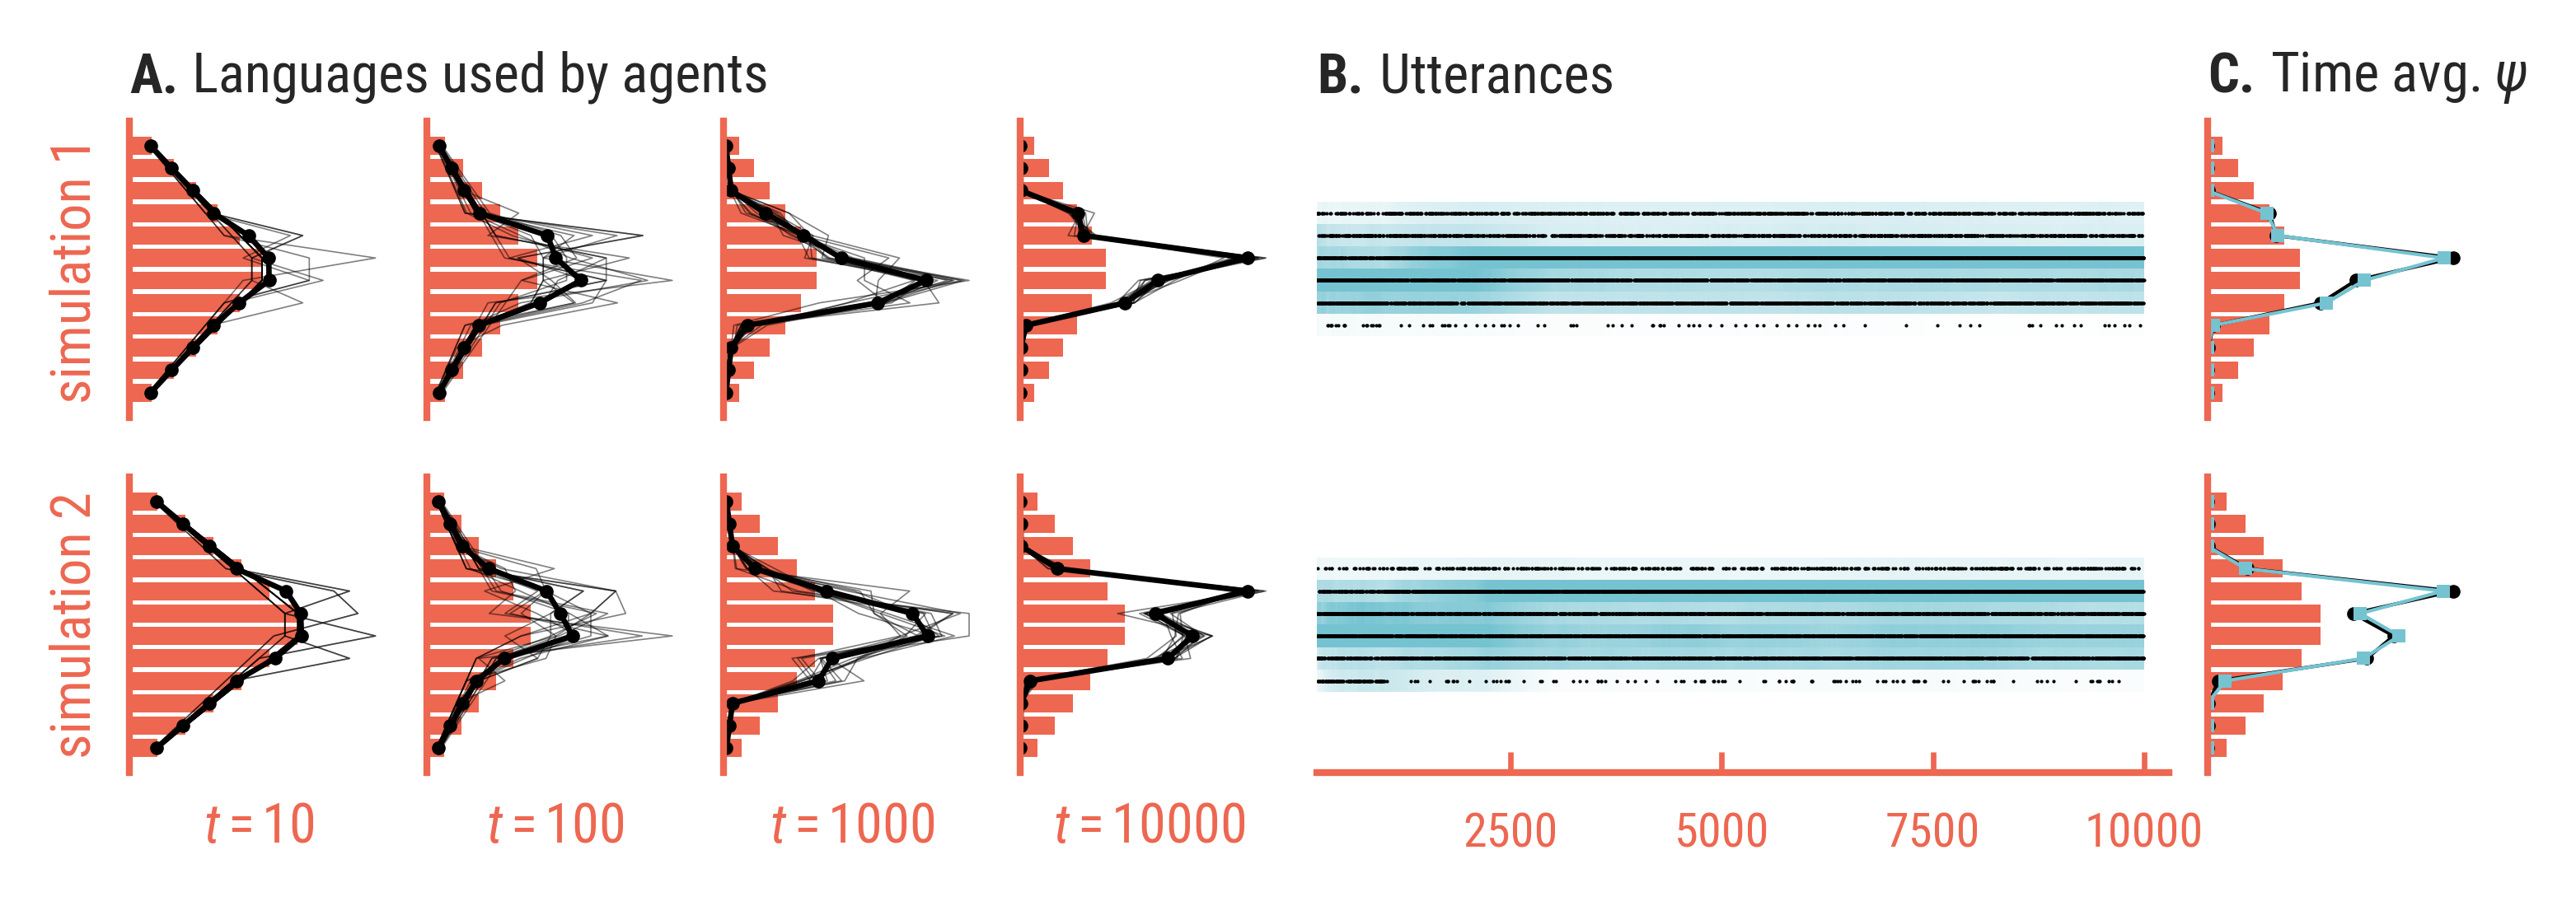

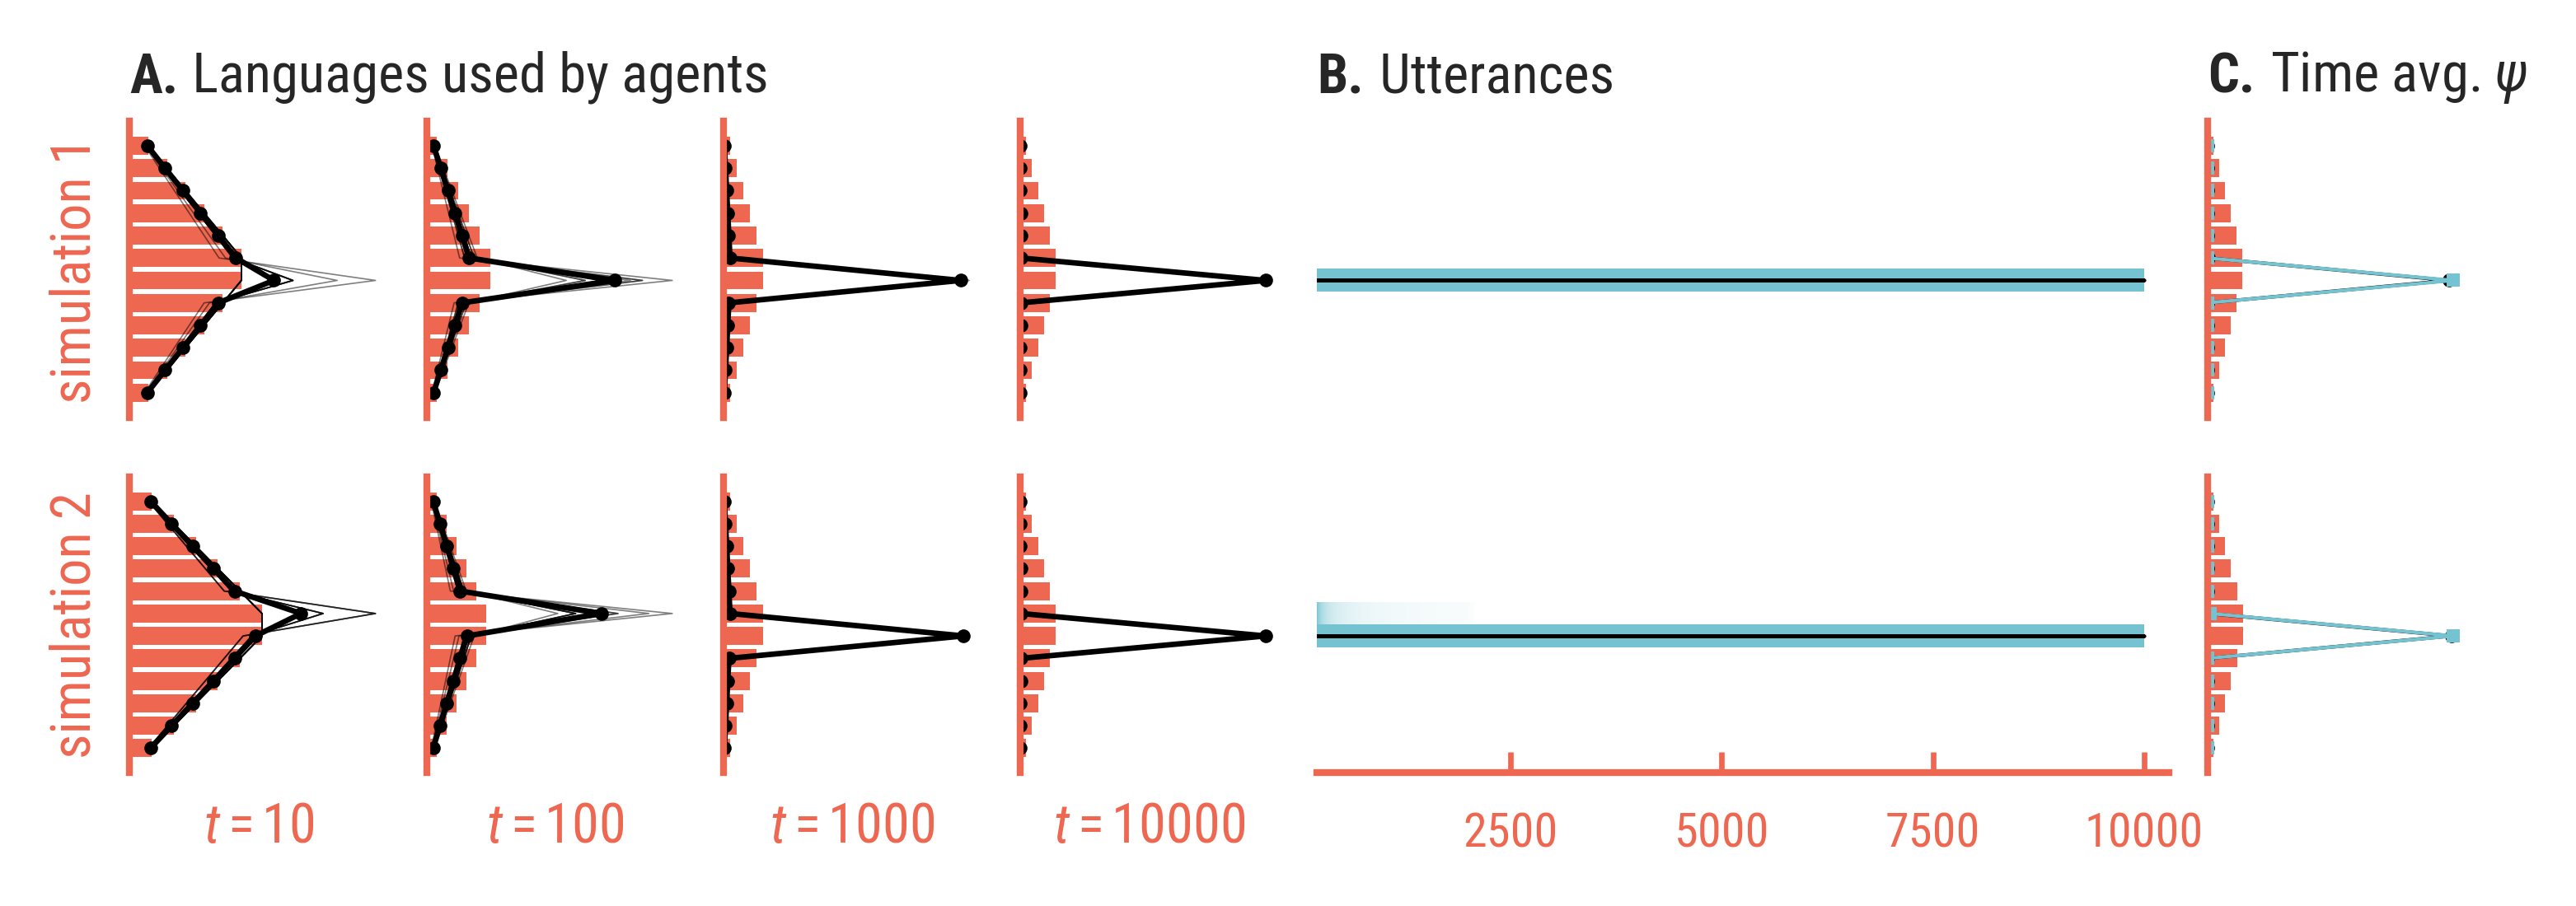

In [7]:
# Plot save and export all 'extreme cases' 
K=12
setup = dict(
    T = 5000, 
    num_datapoints = 100, 
    K = K, 
    N = 15,
    b = 1,
    alpha = K*get_pis(K)['peak'],
    record=False,
    record_utterances=True)

for gamma in [1, 1e20]:
    for eta in [1, 1e20]:
        for zeta in [1, 1e20]:
            setup['eta'] = eta
            setup['zeta'] = zeta
            setup['gamma'] = gamma
            
            # Plot
            # For K=12, figsize= (12,4.5) en corr = 0.45
            figure(figsize=cm2inch(12,3.35))
            plot_runs(setup, runs=2, aspect_correction=.32, window = 2000)
            subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.15)
            _eta = 'inf' if eta == 1e20 else eta
            _zeta = 'inf' if zeta == 1e20 else zeta
            _gamma = 'inf' if gamma == 1e20 else gamma
            fn = f'FIG05-BNG-gamma-{_gamma}-eta-{_eta}-zeta-{_zeta}.png'
            savefig(fn, dpi=450, bbox_inches='tight')
            copyfig(fn)

The rest is old stuff; another visualization that is less clear (I think)

# Convergence towards stable language

In [4]:
def run(init_counts=None, setup=None):
    if init_counts:
        setup['init_counts'] = init_counts
    res = BNG_simulation(**setup)
    vs = res['counts'] + setup['alpha']
    ps = vs / vs.sum(axis=1)[:, np.newaxis]
    return ps, res['counts']

def show_simulation(G, y, setup, titles=False):
    cmap = CustomCmap('white', 'orange')
    
    ax1 = subplot(G[y,0])
    setup['T'] = 10
    ps, counts = run(setup=setup)
    imshow(ps, interpolation='none', cmap=cmap)
    if titles: title('$t = 10$')

    ax2 = subplot(G[y,1])
    setup['T'] = 90
    ps, counts = run(counts, setup=setup)
    imshow(ps, interpolation='none', cmap=cmap)
    if titles: title('$t = 100$')

    ax3 = subplot(G[y,2])
    setup['T'] = 900
    ps, counts = run(counts, setup=setup)
    imshow(ps, interpolation='none', cmap=cmap)
    if titles: title('$t = 1000$')

    ax4 = subplot(G[y,3])
    setup['T'] = 9000
    ps, counts = run(counts, setup=setup)
    imshow(ps, interpolation='none', cmap=cmap)
    if titles: title('$t = 10\; 000$')

    ax5 = subplot(G[y,4])
    setup['T'] = 90000
    ps, counts = run(counts, setup=setup)
    imshow(ps, interpolation='none', cmap=cmap)
    if titles: title('$t = 100\; 000$')
    
    ax6 = subplot(G[y,5])
    xs = arange(setup['K'])
    alpha = array(setup['alpha'])
    pyplot.bar(xs-.5, alpha/sum(alpha), facecolor='k', alpha=.3)
    pyplot.bar(xs-.5,ps.mean(axis=0))
    xlim(0,19.5)
    sns.despine(ax=ax6)
    if titles: title('Limiting dist.')
    
    return [ax1,ax2,ax3,ax4,ax5,ax6]

def plot_runs(setup):
    G = gridspec.GridSpec(4, 6)
    cmap = CustomCmap('white', 'orange')

    axes = []
    axes += show_simulation(G, 0, setup, titles=True)
    axes += show_simulation(G, 1, setup)
    axes += show_simulation(G, 2, setup)

    subplot(G[0,0]).set_ylabel('run 1\nagents')
    subplot(G[1,0]).set_ylabel('run 2\nagents')
    subplot(G[2,0]).set_ylabel('run 3\nagents')
    for x in range(6):
        subplot(G[2,x]).set_xlabel('words')

    restyle_title(*axes, y=1.2, label=False)
    for ax in axes:
        ax.set_yticks([])
        ax.set_xticks([])

In [5]:
# Plot 
figure(figsize=cm2inch(12,6))
K=20
setup = dict(
    T = 5000, 
    num_datapoints = 100, 
    K = K, 
    N = 15,
    b = 1,
    alpha = K*get_pis(K)['peak'],
    record=False,
    record_utterances=False)

for gamma in [1,10000000]:
    for eta in [1,100]:
        for zeta in [1, 100]:
            setup['eta'] = eta
            setup['zeta'] = zeta
            setup['gamma'] = gamma
            plot_runs(setup)
            subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3)
            fn = f'FIG05-language-gamma-{gamma}-eta-{eta}-zeta-{zeta}'
            savefig(fn, dpi=450, bbox_inches='tight')

# Convergence over time

In [ ]:
def plot_utterances_over_time(setup):
    res = BNG_simulation(**setup)
    utter = res['utterances'].todense()
    words = res['utterances'].argmax(axis=1)

    dists = array([np.histogram(words[:t], bins=K, range=(0, K))[0] 
             for t in range(0,len(words),1)])
    dists = dists / dists.max(axis=1)[:, np.newaxis]

    # plot
    ax1 = subplot(121)
    points = utter.argmax(axis=1)
    plot(points, '.',color='#ed6751', ms=2)
    ylabel('word')
    xlabel('time ($t$)')
    xlim(0,5000)
    title('Words uttered at every interaction')
    gca().invert_yaxis()

    ax2 = subplot(122, sharey=ax1)
    alpha = array([setup['alpha']]) / setup['alpha'].max() 
    alpha = np.repeat(alpha, 200, axis=0)# * setup['K']*dists[-1].mean()

    ps = np.concatenate((dists, zeros((300,K)), alpha))
    imshow(ps.T, aspect=71, interpolation='none', cmap=cmap)
    xlabel('time ($t$)')
    title('Convergence of rel. freq. of words')
    xlim(-200, setup['T']+1000)
    ylim((-2, 41))
    sns.despine()
    restyle_title(ax1,ax2)
    
    ax2.annotate(r'$\alpha$', xy=(.96,.5), xytext=(1.05, .5), 
                 xycoords='axes fraction', fontsize = 7.5, 
                 ha='left', va='center',
                 arrowprops=dict(facecolor='black', width=.5, headlength=4, headwidth=3))
    

# figure(figsize=cm2inch(12,3))
# plot_utterances_over_time(setup)    
# subplots_adjust(left=0, bottom=0, right=1, top=1)

In [ ]:
# Plot 
K=40
setup = dict(
    T = 5000, 
    num_datapoints = 100, 
    K = K, 
    N = 15,
    b = 1,
    alpha = beta*get_pis(K)['peak'],
    record=False,
    record_utterances=True)

for gamma in [1,10000000]:
    for eta in [1,100]:
        for zeta in [1, 100]:
            setup['eta'] = eta
            setup['zeta'] = zeta
            setup['gamma'] = gamma
            figure(figsize=cm2inch(12,3))
            plot_utterances_over_time(setup)    
            subplots_adjust(left=0, bottom=0, right=1, top=1)
            fn = f'FIG05-utterances-gamma-{gamma}-eta-{eta}-zeta-{zeta}'
            savefig(fn, dpi=450, bbox_inches='tight')

In [7]:
# Plot 
K=20
setup = dict(
    T = 5000, 
    num_datapoints = 100, 
    K = K, 
    N = 15,
    b = 1,
    alpha = K*get_pis(K)['peak'],
    record=False,
    record_utterances=True)